In [1]:
epochs = 5

# Example - Simple Vertically Partitioned Split Neural Network

- <b>Alice</b>
    - Has model Segment 1
    - Has the handwritten Images
- <b>Bob</b>
    - Has model Segment 2
    - Has the image Labels
    
Based on [SplitNN - Tutorial 3](https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/advanced/split_neural_network/Tutorial%203%20-%20Folded%20Split%20Neural%20Network.ipynb) from Adam J Hall - Twitter: [@AJH4LL](https://twitter.com/AJH4LL) · GitHub:  [@H4LL](https://github.com/H4LL)

Authors:
- Pavlos Papadopoulos · GitHub:  [@pavlos-p](https://github.com/pavlos-p)
- Tom Titcombe · GitHub:  [@TTitcombe](https://github.com/TTitcombe)
- Robert Sandmann · GitHub: [@rsandmann](https://github.com/rsandmann)


In [2]:
class SplitNN:
    def __init__(self, models, optimizers):
        self.models = models
        self.optimizers = optimizers

        self.data = []
        self.remote_tensors = []

    def forward(self, x):
        data = []
        remote_tensors = []

        data.append(self.models[0](x))

        if data[-1].location == self.models[1].location:
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            remote_tensors.append(
                data[-1].detach().move(self.models[1].location).requires_grad_()
            )

        i = 1
        while i < (len(models) - 1):
            data.append(self.models[i](remote_tensors[-1]))

            if data[-1].location == self.models[i + 1].location:
                remote_tensors.append(data[-1].detach().requires_grad_())
            else:
                remote_tensors.append(
                    data[-1].detach().move(self.models[i + 1].location).requires_grad_()
                )

            i += 1

        data.append(self.models[i](remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors

        return data[-1]

    def backward(self):
        for i in range(len(models) - 2, -1, -1):
            if self.remote_tensors[i].location == self.data[i].location:
                grads = self.remote_tensors[i].grad.copy()
            else:
                grads = self.remote_tensors[i].grad.copy().move(self.data[i].location)
    
            self.data[i].backward(grads)

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def step(self):
        for opt in self.optimizers:
            opt.step()

In [3]:
import sys
sys.path.append('../')

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [4]:
import syft as sy

In [5]:
from src.dataloader import VerticalDataLoader
from src.psi.util import Client, Server
from src.utils import add_ids

In [6]:
hook = sy.TorchHook(torch) # no longer supported in the later version of pysyft

In [7]:
# Create dataset
data = add_ids(MNIST)(".", download=True, transform=ToTensor())  # add_ids adds unique IDs to data points

# Batch data
dataloader = VerticalDataLoader(data, batch_size=128) # partition_dataset uses by default "remove_data=True, keep_order=False"

4.6%

100.1%

Extracting ./VerticalDataset/raw/train-images-idx3-ubyte.gz to ./VerticalDataset/raw


22.4%%

Extracting ./VerticalDataset/raw/train-labels-idx1-ubyte.gz to ./VerticalDataset/raw


180.4%

Extracting ./VerticalDataset/raw/t10k-images-idx3-ubyte.gz to ./VerticalDataset/raw
Extracting ./VerticalDataset/raw/t10k-labels-idx1-ubyte.gz to ./VerticalDataset/raw
Processing...
Done!


## Check if the datasets are unordered
In MNIST, we have 2 datasets (the images and the labels).

6 1 5 1 8 3 0 7 8 7 

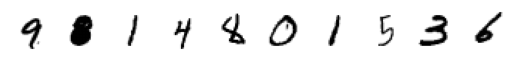

In [8]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

## Implement PSI and order the datasets accordingly

In [9]:
# Compute private set intersection
client_items = dataloader.dataloader1.dataset.get_ids()
server_items = dataloader.dataloader2.dataset.get_ids()

client = Client(client_items)
server = Server(server_items)

setup, response = server.process_request(client.request, len(client_items))
intersection = client.compute_intersection(setup, response)

# Order data
dataloader.drop_non_intersecting(intersection)
dataloader.sort_by_ids()

## Check again if the datasets are ordered

8 4 8 3 8 1 4 5 1 6 

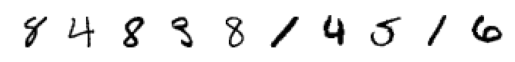

In [10]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

In [13]:
torch.manual_seed(0)

# Define our model segments

input_size = 784
hidden_sizes = [128, 640]
output_size = 10

models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size), nn.LogSoftmax(dim=1)),
]

# Create optimisers for each segment and link to them
optimizers = [
    optim.SGD(model.parameters(), lr=0.03,)
    for model in models
]

# create some workers
alice = sy.VirtualWorker(hook,id="alice")
bob = sy.VirtualWorker(hook,id="bob")

In [14]:
# Send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = SplitNN(models, optimizers)

In [15]:
print(dir(models))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [16]:
def train(x, target, splitNN):
    
    #1) Zero our grads
    splitNN.zero_grads()
    
    #2) Make a prediction
    pred = splitNN.forward(x)
    
    #3) Figure out how much we missed by
    criterion = nn.NLLLoss()
    loss = criterion(pred, target)
    
    #4) Backprop the loss on the end layer
    loss.backward()
    
    #5) Feed Gradients backward through the nework
    splitNN.backward()
    
    #6) Change the weights
    splitNN.step()
    
    return loss, pred

In [17]:
for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data, labels, splitNN)

        # Collect statistics
        running_loss += loss.get()
        correct_preds += preds.max(1)[1].eq(labels).sum().get().item()
        total_preds += preds.get().size(0)

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 1.143 - Accuracy: 73.052
Epoch 1 - Training loss: 0.384 - Accuracy: 89.132
Epoch 2 - Training loss: 0.317 - Accuracy: 90.932
Epoch 3 - Training loss: 0.281 - Accuracy: 91.952
Epoch 4 - Training loss: 0.253 - Accuracy: 92.710


In [18]:
print("Labels pointing to: ", labels)
print("Images pointing to: ", data)

Labels pointing to:  (Wrapper)>[PointerTensor | me:15217108057 -> bob:49298730621]
Images pointing to:  (Wrapper)>[PointerTensor | me:61139349324 -> alice:4456034781]
